In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models
from torchvision.models.vgg import VGG
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import nibabel as nib
import time
import datetime
import torch.nn.functional as F
import seaborn as sns
from models.unet import UNet
from metrics.torch_seg_metrics import dice_score, iou
from datasets.BRATS2018 import ToTensor, NormalizeBRATS, ZeroPad

%matplotlib inline

In [9]:
def get_inference_model(input_channels, num_classes, device, model_path):
    model = UNet(n_channels=input_channels, n_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    ts = time.time()
    model = model.to(device)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))
    
    return model

def visualize_inference(model_path, device, base_path, img_name, model_type='unet', seg_type='et', scan_type='t1ce'):
    """
    Plot the original image, predicted dense labels and the ground-true labels.
    Parameters:
    - model: PyTorch model
    - base_path: path to the augmented Pascal VOC dataset
    - img_name: image file name without format extension
                e.g. 2008_000073 is the img_path for 2008_000073.jpg and 2008_000073.mat
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 20))
    voc_colors = [[0, 0, 0], [0, 192, 0]]

    voc_classes = ['background', f'{seg_type}']
    
    scan_path = os.path.join(base_path, img_name + '_scan.npy')
    mask_path = os.path.join(base_path, img_name + f'_{seg_type}.npy')
    ind2color = {}
    legend_elements = []
    for ind, color in enumerate(voc_colors):
        ind2color[ind] = (color, voc_classes[ind])
        legend_elements.append(Line2D([0], [0], color=np.array(color)/255, lw=6))
    
    ax1.set_title('original image')
    if scan_type == 't1ce':
        sc = np.load(scan_path)[1]
        ax1.imshow(sc)
        sc = np.expand_dims(sc, axis=0)
        assert sc.shape == (1, 240, 240)
        model = get_inference_model(input_channels=1, num_classes=1, device=device, model_path=model_path)
    elif scan_type == 'flair':
        sc = np.load(scan_path)[3]
        ax1.imshow(sc)
        sc = np.expand_dims(sc, axis=0)
        assert sc.shape == (1, 240, 240)
        model = get_inference_model(input_channels=1, num_classes=1, device=device, model_path=model_path)
    elif scan_type == 't2-flair':
        sc = np.load(scan_path)[2:]
        ax1.imshow(sc[1])
        assert sc.shape == (2, 240, 240)
        model = get_inference_model(input_channels=2, num_classes=1, device=device, model_path=model_path)
    else:
        raise ValueError('Scan type should only be t1ze, flair, or t2-flair!')
    
    
    mask = np.load(mask_path)
    assert mask.shape == (240, 240)
        
    
    zero_pad = ZeroPad()
    to_tensor = ToTensor()
    normalize_BraTS = NormalizeBRATS()
    if not model_type == 'unet':
        sc, mask = zero_pad((sc, mask))
        assert sc.shape == (1, 256, 256)
        assert mask.shape == (256, 256)
        
    sc, mask = normalize_BraTS((sc, mask))
    sc, mask = to_tensor((sc, mask))
    
    sc = sc.to(device)
    mask = mask.to(device)
    
    # unsqueeze to 4-dimension NxCxHxW
    sc = torch.unsqueeze(sc, dim=0)
    model.eval()
    with torch.no_grad():
        output = model(sc)
        #pred = torch.argmax(F.softmax(output, dim=1), dim=1)
        pred = torch.sigmoid(output)
        pred = pred > 0.5
    
    # squeeze the dense label back to a 2-dimension tensor
    pred = torch.squeeze(pred)
    
    if not model_type == 'unet':
        pred = pred[8: -8, 8: -8]
        mask = mask[8: -8, 8: -8]

    
    dice = dice_score(pred, mask)
    #mIOU = iou(pred, mask, 2)
    print(f'dice score: {dice}')
    #print(f'dice score: {dice}, mIOU: {mIOU}')
    
    mask = mask.cpu().numpy()
    pred = pred.cpu().numpy()
    height, width = pred.shape
    
    colored_pred = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_pred[h, w] = ind2color[pred[h, w]][0]
    
    ax2.set_title('predicted feature map')
    ax2.imshow(colored_pred)
    
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_mask[h, w] = ind2color[mask[h, w]][0]
            
    ax3.set_title('ground true dense label')
    ax3.legend(handles=legend_elements, labels=voc_classes, loc='upper center', bbox_to_anchor=(1.5, 1.2))
    ax3.imshow(colored_mask)

## Whole tumor segmentation

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
base_path = './BRATS2018/seg/val/'

In [4]:
wt_checkpoint = torch.load('../UNet_BraTS_DiceLoss_WT_manual/UNets-BRATS2018-DiceLoss-WT_batch6_lr1e-5_gamma1.0/terminated_model.tar',\
                           map_location=device)
unet_wt = UNet(n_channels=1, n_classes=1)
unet_wt.load_state_dict(wt_checkpoint['model_state_dict'])

-Dice score- intersection: 3408.00, preds: 3445.00, targets: 3717.00
dice score: 0.9516894817352295


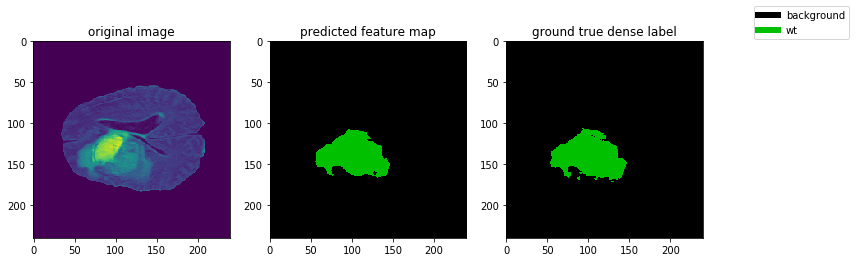

In [5]:
visualize_inference(unet_wt, base_path, img_name='Brats18_CBICA_AXO_1_085', seg_type='wt', scan_type='flair')

In [9]:
wt_t2_flair_checkpoint = torch.load('../UNet_BraTS_DiceLoss_WT_210_manual/UNets-BRATS2018-WT-210-T2-Flair_batch6_training_epochs10_Adam_scheduler-step10-gamma1.0_lr1e-05_w_decay1e-05/trained_model_checkpoint.tar',\
                                   map_location=device)
unet_t2_flair = UNet(n_channels=2, n_classes=1)
unet_t2_flair.load_state_dict(wt_t2_flair_checkpoint['model_state_dict'])

-Dice score- intersection: 234.00, preds: 259.00, targets: 323.00
dice score: 0.8041253685951233


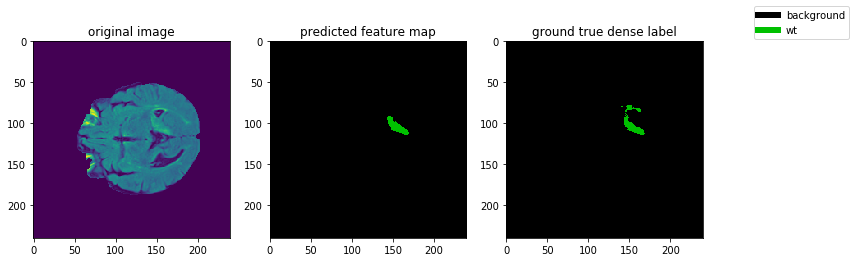

In [20]:
visualize_inference(unet_t2_flair, base_path, img_name='Brats18_TCIA06_409_1_065', seg_type='wt', scan_type='t2-flair')

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
base_path = './BRATS2018/seg/val/'

Finish cuda loading, time elapsed 0.043785810470581055
-Dice score- intersection: 2928.00, preds: 3141.00, targets: 2942.00
dice score: 0.9626829028129578


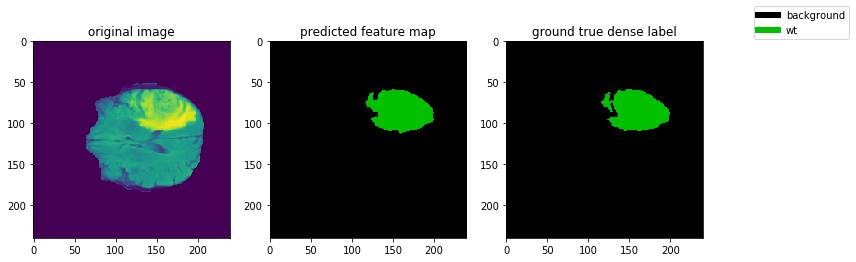

In [12]:
visualize_inference(model_path='../UNet_BraTS_DiceLoss_WT_210_manual/UNets-BRATS2018-WT-210-T2-Flair_batch6_training_epochs10_Adam_scheduler-step10-gamma1.0_lr1e-05_w_decay1e-05/trained_model.pt',\
                   device=device, base_path=base_path, img_name='Brats18_TCIA04_361_1_084', seg_type='wt', scan_type='t2-flair')

## Enhancing tumor

In [6]:
et_checkpoint = torch.load('../UNet_BraTS_DiceLoss_ET_manual/UNets-BRATS2018-ET-DiceLoss_batch6_training_epochs50_Adam_scheduler-step10-gamma1.0_lr0.0001_w_decay1e-05/terminated_model.tar',\
                           map_location=device)
unet_et = UNet(n_channels=1, n_classes=1)
unet_et.load_state_dict(et_checkpoint['model_state_dict'])

-Dice score- intersection: 390.00, preds: 562.00, targets: 571.00
dice score: 0.688439130783081


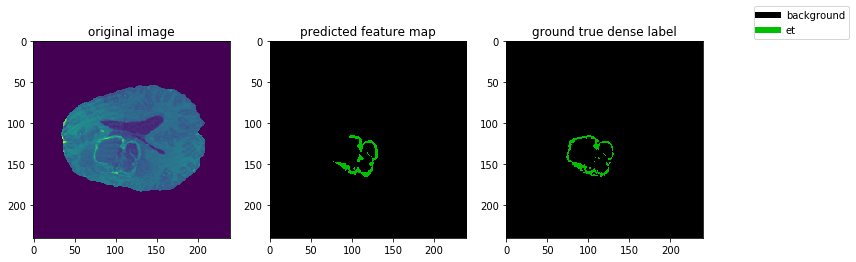

In [7]:
visualize_inference(unet_et, base_path, img_name='Brats18_CBICA_AXO_1_085', seg_type='et')

Finish cuda loading, time elapsed 0.037004709243774414
-Dice score- intersection: 1072.00, preds: 1081.00, targets: 1291.00
dice score: 0.9038788080215454


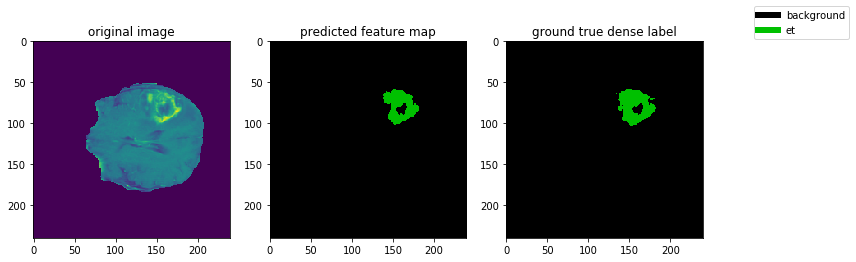

In [13]:
visualize_inference(model_path='../UNet_BraTS_DiceLoss_ET_manual/UNets-BRATS2018-ET-DiceLoss_batch6_training_epochs50_Adam_scheduler-step10-gamma1.0_lr0.0001_w_decay1e-05/terminated_model.pt',\
                   device=device, base_path=base_path, img_name='Brats18_TCIA04_361_1_084', seg_type='et', scan_type='t1ce')

## Tumor core

In [5]:
tc_checkpoint = torch.load('../UNet_BraTS_DiceLoss_TC_manual/UNets-BRATS2018-TC-DiceLoss_batch6_training_epochs50_Adam_scheduler-step10-gamma1.0_lr1e-05_w_decay1e-05/terminated_model.tar',\
                           map_location=device)
unet_tc = UNet(n_channels=1, n_classes=1)
unet_tc.load_state_dict(tc_checkpoint['model_state_dict'])

-Dice score- intersection: 2120.00, preds: 2208.00, targets: 2199.00
dice score: 0.9621058106422424


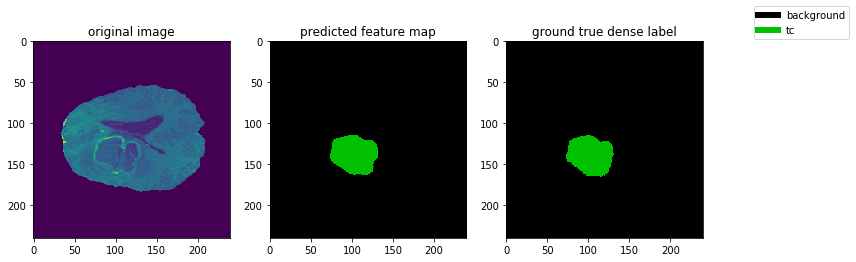

In [6]:
visualize_inference(unet_tc, base_path, img_name='Brats18_CBICA_AXO_1_085', seg_type='tc')

Finish cuda loading, time elapsed 0.036867618560791016
-Dice score- intersection: 1265.00, preds: 1266.00, targets: 1458.00
dice score: 0.9287813305854797


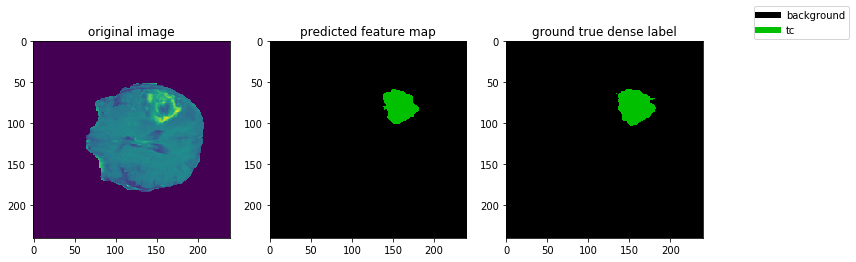

In [14]:
visualize_inference(model_path='../UNet_BraTS_DiceLoss_TC_manual/UNets-BRATS2018-TC-DiceLoss_batch6_training_epochs50_Adam_scheduler-step10-gamma1.0_lr1e-05_w_decay1e-05/terminated_model.pt',\
                   device=device, base_path=base_path, img_name='Brats18_TCIA04_361_1_084', seg_type='tc', scan_type='t1ce')